# Fine Tuning Transformer for MultiLabel Text Classification

## Mounting Drive to retrieve Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# installing Transformer
!pip install -q transformers

     |████████████████████████████████| 1.9MB 6.1MB/s 
     |████████████████████████████████| 3.2MB 56.7MB/s 
     |████████████████████████████████| 890kB 56.2MB/s 


## Importing Libraries

In [ ]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import seaborn
import transformers
import torch
import nltk
import re
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download("stopwords")
from nltk.stem import PorterStemmer
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from torch import cuda, nn
nltk.download("punkt")

device = 'cuda' if cuda.is_available() else 'cpu'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## This is the focal Loss which is used for unbalanced classes.

In [ ]:
def focal_loss(targets,logits,eps,l):
    ce_loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction= 'none')
    pt = torch.exp(-ce_loss)
    loss = (eps * (1-pt)**l * ce_loss).mean()
    return loss

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/data/CallsData.csv")                        # Reading data
labels = pd.DataFrame(columns=['Mention TDL', 'Needs Follow Up', 'Reviewed', 'Appointment Set', 'New Customer', 'Called Back'])    # Creating hard coded label columns
new = pd.concat([df, labels], axis=1)
for i, each in enumerate(df['Tags']):
    for j, every in enumerate(labels):
        if every in each:
            new[every][i] = 1
        else: new[every][i] = 0 

df_train = new.copy()          # Created new dataframe by filling 1 and 0 for each label described
df_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Unnamed: 0,Tags,text,Mention TDL,Needs Follow Up,Reviewed,Appointment Set,New Customer,Called Back
0,0,"Mention TDL, Needs Follow Up, Reviewed",Speaker 0 00:00 This call may be monitor...,1,1,1,0,0,0
1,1,"Appointment Set, New Customer, Reviewed",Speaker 0 00:00 This call may be monitor...,0,0,1,1,1,0
2,2,"Appointment Set, Called Back, Reviewed",Speaker 0 00:00 This call may be monitor...,0,0,1,1,0,1
3,3,"Reviewed, Solicitor",Speaker 0 00:00 This call may be monitor...,0,0,1,0,0,0
4,4,"Appointment Set, New Customer, Reviewed",Speaker 0 00:00 This call may be monitor...,0,0,1,1,1,0


## Now after processing the label the time comes to refine the text/features for the model

In [ ]:
NON_ALPHANUM = re.compile(r'[\W]')      # Removing Alpha numerical Characters
NON_ASCII = re.compile(r'[^a-z\s]')     # keeping only alphabets
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')    # Removing stopwords here using regex
porter = PorterStemmer()                # Stemming technique to map similar words
def normalize_texts(texts):
    normalized_texts = []
    for text in texts:
        text = pattern.sub('', text)
        lower = text.lower()
        no_punctuation = NON_ALPHANUM.sub(r' ', lower)
        no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
        dede = porter.stem(no_non_ascii.strip())
        normalized_texts.append(dede)     # Final List with refined data
    return normalized_texts     

In [ ]:
df_train['text'] = normalize_texts(df_train['text'])     # Appending it into a Dataframe column

In [ ]:
df_train['Class'] = df_train[df_train.columns[3:]].values.tolist()     # One hot encoded vectors for the label. because BERT only accept vectors
new_df = df_train[['text', 'Class']].copy()
new_df.head()

,text,Class
0,speaker this call may monitored recor...,"[1, 1, 1, 0, 0, 0]"
1,speaker this call may monitored recor...,"[0, 0, 1, 1, 1, 0]"
2,speaker this call may monitored recor...,"[0, 0, 1, 1, 0, 1]"
3,speaker this call may monitored hell...,"[0, 0, 1, 0, 0, 0]"
4,speaker this call may monitored recor...,"[0, 0, 1, 1, 1, 0]"


In [ ]:
type(new_df['Class'][0][0])

int

In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 100
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', return_dict=False)

## Custome class to make the code for the dataset you want to work on

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.text
        self.targets = self.data.Class
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_size = 0.8
train_dataset = new_df.sample(frac=train_size,random_state=200)
test_dataset = new_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

FULL Dataset: (16383, 2)
TRAIN Dataset: (13106, 2)
TEST Dataset: (3277, 2)


## Data Loaders to convert data to tensors for the model

In [ ]:
training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)
training_loader = DataLoader(training_set, batch_size = TRAIN_BATCH_SIZE, num_workers=0, shuffle = True)
testing_loader = DataLoader(testing_set, batch_size = VALID_BATCH_SIZE, num_workers=0, shuffle = True)

## Pre-Trained BERT model and the last dense layer for decision

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 6)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [ ]:
criterion = nn.BCEWithLogitsLoss()     # we can use it for cross entropy loss. in case of focal loss we don't need this
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

## Main training function 

In [ ]:
def CallsTrain(model, training_loader, testing_loader, Epochs, name):

    model.train()
    history = []
    for epoch in range(Epochs):  # loop over the dataset multiple times
        total_train = 0
        train_loss = 0.0
        valid_loss = 0.0
        running_loss = 0.0
        correct = 0
        total = 0
        vcorrect = 0
        predicted = []
        train_acc = 0
        valid_acc = 0
        vtotal = 0
        # pbar = tqdm() 
        for _,data in enumerate(training_loader, 0):    # Getting the batches every iteration

            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            optimizer.zero_grad()
            outputs = model(ids, mask, token_type_ids)
            loss = focal_loss(outputs, targets, 0.25, 2 )   #----> compute loss
            loss.backward()                     #----> backward pass
            optimizer.step()                   #----> weights update
            outputs[outputs >= 0.5] = 1        # ----> predicting them into classes based on probability
            outputs[outputs < 0.5] = 0
            correct += (outputs == targets).sum().item()    # Accuracy for every batch
            total += targets.size(0)
            running_loss += loss.item()        # Adding loss for every batch size
            
        for _,data in enumerate(testing_loader, 0):

            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            optimizer.zero_grad()
            outputs = model(ids, mask, token_type_ids)
            loss = focal_loss(outputs, targets, 0.25, 2 )   #----> compute loss
            loss.backward()                     #----> backward pass
            optimizer.step()                   #----> weights update
            outputs[outputs >= 0.5] = 1
            outputs[outputs < 0.5] = 0
            vcorrect += (outputs == targets).sum().item()
            vtotal += targets.size(0)
            valid_loss += loss.item()

        train_loss = running_loss / len(training_loader)
        valid_loss = valid_loss / len(testing_loader)
        train_acc = correct / total
        valid_acc = vcorrect / vtotal

        history.append([train_loss, valid_loss, train_acc, valid_acc])
        print('Epoch #', epoch, '\t\tTraining loss: ', train_loss, '\t Validation loss: ', valid_loss)
        print('\t\tTraining Accuracy: ', (100 * train_acc)/6, '\t Validation Accuracy: ', (100 * valid_acc/6))
    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    torch.save(model.state_dict(), './gdrive/My Drive/' + name)
    return model, history

In [ ]:
model, history = CallsTrain(model, training_loader, testing_loader, Epochs = 10, name = '/Bert.pth')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch # 0 		Training loss:  0.3967468685279029 	 Validation loss:  0.37745873015828246
		Training Accuracy:  81.17783203621751 	 Validation Accuracy:  81.37015563014953
Epoch # 1 		Training loss:  0.36053943351283896 	 Validation loss:  0.3490253522265248
		Training Accuracy:  82.41390711633348 	 Validation Accuracy:  82.96205879361204
Epoch # 2 		Training loss:  0.3395416174649901 	 Validation loss:  0.3097464337490681
		Training Accuracy:  83.78732387201791 	 Validation Accuracy:  85.81019224900824
Epoch # 3 		Training loss:  0.3124681214749122 	 Validation loss:  0.26339839397952325
		Training Accuracy:  85.75334452413652 	 Validation Accuracy:  88.42437188485404
Epoch # 4 		Training loss:  0.2804831619294334 	 Validation loss:  0.2230631457187417
		Training Accuracy:  87.71555012971157 	 Validation Accuracy:  90.78425389075375
Epoch # 5 		Training loss:  0.25167135926119216 	 Validation loss:  0.19279708564281464
		Training Accuracy:  89.30133780965461 	 Validation Accuracy:  91.92

## Plotting the results to see the trend of the data. like overfitting etc

Text(0.5, 1.0, 'Training and Validation Accuracy')

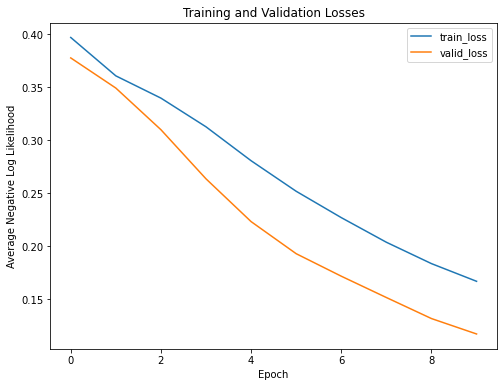

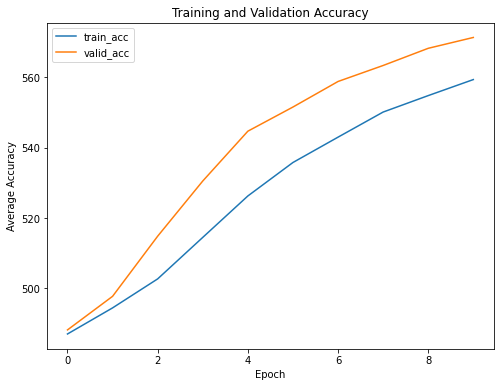

In [ ]:
# Just run it on 10 epoch to see whether it is working fine or not

plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')